# Phenolytics QSAR Analysis 

In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score


In [20]:
# Import the preporcessed dataset with descriptors for downstream analysis and modeling

# Path 
csv_path = "/home/omid/Documents/Data/phenolics_full_descriptors.csv"

# Load the CSV
df = pd.read_csv(csv_path)
print("First 5 rows of your data:")
print(df.head())

# Extract compound names as a Python list
compounds = df['Compound'].tolist()
print(f"\nTotal compounds: {len(compounds)}")
print("Some example compounds:", compounds[:5])

# Save a simple text file with compounds for MOPAC input
output_txt = "/home/omid/Documents/Data/phenolics_list.txt"
with open(output_txt, "w") as f:
    for cmpd in compounds:
        f.write(cmpd + "\n")
print(f"\nCompound names saved to: {output_txt}")

First 5 rows of your data:
           Compound  Heat_of_Formation   HOMO   LUMO  Dipole_Moment  \
0      Caffeic acid          -72.08402 -8.061 -2.444       11.94241   
1  Chlorogenic acid         -335.71654 -8.455 -1.265        4.67145   
2   o-Coumaric acid           -4.39060 -8.569 -1.417        8.34206   
3   m-Coumaric acid          -83.27963 -9.218 -0.956        5.71151   
4   p-Coumaric acid          -20.22144 -8.678 -1.992        5.12332   

   Cosmo_Area  Num_Hydroxyl  TEAC   \
0      200.05             2   1.31   
1      349.78             2   1.56   
2      190.42             1   0.93   
3      186.06             1   0.82   
4      190.89             1   1.96   

                                              SMILES    MolWt  ...       Chi0  \
0                         C1=CC(=C(C=C1C=CC(=O)O)O)O  180.159  ...   9.844935   
1  C1C(C(C(CC1(C(=O)O)O)OC(=O)C=CC2=CC(=C(C=C2)O)...  354.311  ...  18.775656   
2                          C1=CC=C(C(=C1)C=CC(=O)O)O  164.160  ...   8.974

In [21]:
# Check for leading/trailing spaces in column names
print(df.columns.tolist())

df.columns = df.columns.str.strip()

['Compound', 'Heat_of_Formation', 'HOMO', 'LUMO', 'Dipole_Moment', 'Cosmo_Area', 'Num_Hydroxyl', 'TEAC ', 'SMILES', 'MolWt', 'HeavyAtomCount', 'RingCount', 'NumAromaticRings', 'NumAliphaticRings', 'NumRotatableBonds', 'TPSA', 'MolLogP', 'FractionCSP3', 'Chi0', 'Chi1', 'Chi0v', 'Chi1v', 'Kappa1', 'Kappa2', 'Kappa3', 'BalabanJ', 'BertzCT', 'HallKierAlpha']


In [22]:

# Drop SMILES for modeling
X = df.drop(columns=['SMILES', 'TEAC',"Compound"])  # assuming TEAC is your target

# Target variable
y = df['TEAC']


# Feature Selection For Downstream Analysis 

# Method A :

In [23]:
# Correlation Analysis
import numpy as np

corr_matrix = pd.DataFrame(X, columns=X.columns).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Highly correlated features to drop:", to_drop)

# Drop them
X_reduced = pd.DataFrame(X, columns=X.columns).drop(columns=to_drop)


Highly correlated features to drop: ['MolWt', 'HeavyAtomCount', 'TPSA', 'Chi0', 'Chi1', 'Chi0v', 'Chi1v', 'Kappa1', 'Kappa2', 'Kappa3', 'BertzCT', 'HallKierAlpha']


In [24]:
X_reduced.head()

,Heat_of_Formation,HOMO,LUMO,Dipole_Moment,Cosmo_Area,Num_Hydroxyl,RingCount,NumAromaticRings,NumAliphaticRings,NumRotatableBonds,MolLogP,FractionCSP3,BalabanJ
0,-72.08402,-8.061,-2.444,11.94241,200.05,2,1,1,0,2,1.1956,0.000,2.915115
1,-335.71654,-8.455,-1.265,4.67145,349.78,2,2,1,1,4,-0.6459,0.375,2.058884
2,-4.39060,-8.569,-1.417,8.34206,190.42,1,1,1,0,2,1.4900,0.000,2.891571
3,-83.27963,-9.218,-0.956,5.71151,186.06,1,1,1,0,2,1.4900,0.000,2.826395
4,-20.22144,-8.678,-1.992,5.12332,190.89,1,1,1,0,2,1.4900,0.000,2.772026


Num_Hydroxyl         0.441897
HOMO                 0.167398
LUMO                 0.080716
BalabanJ             0.069215
MolLogP              0.057948
Dipole_Moment        0.045910
Cosmo_Area           0.034325
Heat_of_Formation    0.030580
NumRotatableBonds    0.029589
RingCount            0.020721
NumAromaticRings     0.009736
FractionCSP3         0.008467
NumAliphaticRings    0.003498
dtype: float64


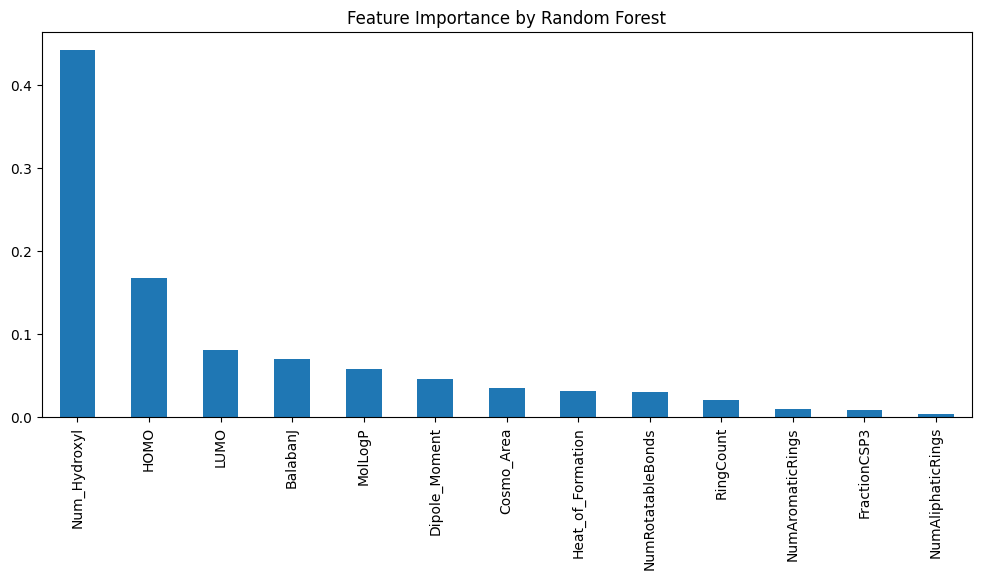

In [25]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_reduced, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_reduced.columns).sort_values(ascending=False)
print(importances)

# Plot
importances.plot(kind='bar', figsize=(12,5))
plt.title("Feature Importance by Random Forest")
plt.show()


# Linear Modelling with the selected features from method A: 

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [27]:
top_5_features = ['Num_Hydroxyl', 'HOMO', 'LUMO',"BalabanJ","Dipole_Moment"]

selected_cols_corr = importances # list of column names
selected_cols_corr = importances.index.tolist() # list of column names
selected_cols_corr


['Num_Hydroxyl',
 'HOMO',
 'LUMO',
 'BalabanJ',
 'MolLogP',
 'Dipole_Moment',
 'Cosmo_Area',
 'Heat_of_Formation',
 'NumRotatableBonds',
 'RingCount',
 'NumAromaticRings',
 'FractionCSP3',
 'NumAliphaticRings']

In [28]:


# To add the target back to a temporary dataframe for analysis:
df_reduced_corr = df[selected_cols_corr].copy()
df_reduced_corr["TEAC"] = y  # Just use 'y' directly

# Setup X and y for the model
X_selected = X_reduced[top_5_features]# Make sure TEAC is removed from X!
# y is already defined, no need to do y = y.values again

In [29]:
X_selected.head(3)

,Num_Hydroxyl,HOMO,LUMO,BalabanJ,Dipole_Moment
0,2,-8.061,-2.444,2.915115,11.94241
1,2,-8.455,-1.265,2.058884,4.67145
2,1,-8.569,-1.417,2.891571,8.34206


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X_selected,
y,
test_size=0.3,
random_state=42
)
print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")

Train set size: (43, 5), Test set size: (19, 5)


In [31]:
X_train.head(2)

,Num_Hydroxyl,HOMO,LUMO,BalabanJ,Dipole_Moment
8,3,-9.490,-1.419,3.306535,4.63150
6,1,-8.852,-0.889,2.914616,7.47249


In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = model.predict(X_test)

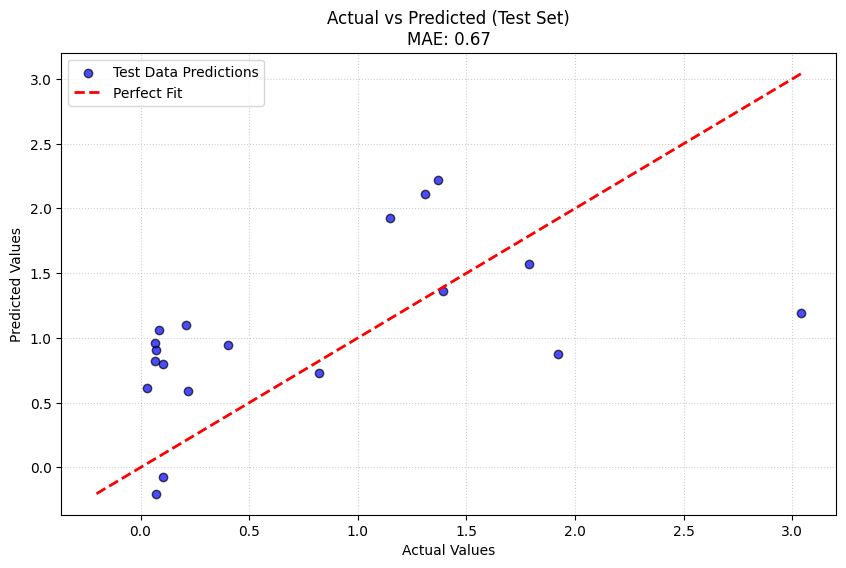

Test R2 Score: 0.1204


In [34]:
# Visualize the Results
plt.figure(figsize=(10, 6))

# Plotting Actual vs Predicted
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7, label='Test Data Predictions')

# Draw a diagonal line (Perfect Prediction Line)
# If points are on this line, the model is 100% accurate
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (Test Set)\nMAE: {mean_absolute_error(y_test, y_pred):.2f}')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 5. Measure Efficacy on Test Data
print(f"Test R2 Score: {r2_score(y_test, y_pred):.4f}")

In [35]:
# Check the coefficients
#features_importance = pd.DataFrame({'Feature': X.columns, 'Coeff': model.coef_})
#print(features_importance.sort_values(by='Coeff', ascending=False))

# Method B:

This method applies SVR to the removed correlated dataset then applies Recurssive Features Elemination and selects through Leave One Out Cross Validation !

In [36]:
import numpy as np
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from collections import Counter

X = df.drop(columns=['SMILES', 'TEAC',"Compound"])
y = df['TEAC']

loo = LeaveOneOut()

# MUST be outside the loop
feature_counter = Counter()

y_true, y_pred = [], []

for train_idx, test_idx in loo.split(X):

    # -----------------------------
    # Split
    # -----------------------------
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # -----------------------------
    # Correlation filtering (TRAIN ONLY)
    # -----------------------------
    corr = X_train.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [c for c in upper.columns if any(upper[c] > 0.85)]

    X_train_red = X_train.drop(columns=drop_cols)
    X_test_red  = X_test.drop(columns=drop_cols)

    # Safety guard
    if X_train_red.shape[1] == 0:
        X_train_red = X_train.copy()
        X_test_red  = X_test.copy()

    # -----------------------------
    # Scaling
    # -----------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_red)
    X_test_scaled  = scaler.transform(X_test_red)

    # -----------------------------
    # SVR + RFE (linear kernel for ranking)
    # -----------------------------
    n_select = min(8, X_train_red.shape[1])
    rfe = RFE(
        estimator=SVR(kernel='linear'),
        n_features_to_select=n_select
    )

    X_train_sel = rfe.fit_transform(X_train_scaled, y_train)
    X_test_sel  = rfe.transform(X_test_scaled)

    # THIS is where feature importance is collected
    selected_features = X_train_red.columns[rfe.support_]
    feature_counter.update(selected_features)

    # -----------------------------
    # Final SVR (nonlinear)
    # -----------------------------
    svr = SVR(kernel='rbf', C=10, gamma='scale')
    svr.fit(X_train_sel, y_train)

    y_pred.append(svr.predict(X_test_sel)[0])
    y_true.append(y_test.values[0])

# -----------------------------
# After LOOCV finishes
# -----------------------------
feature_importance = (
    pd.Series(feature_counter)
    .sort_values(ascending=False)
)

print(feature_importance)


Heat_of_Formation    62
HOMO                 62
Num_Hydroxyl         62
FractionCSP3         62
RingCount            59
BalabanJ             55
NumAliphaticRings    51
LUMO                 50
MolLogP              24
NumAromaticRings      6
NumRotatableBonds     2
Cosmo_Area            1
dtype: int64


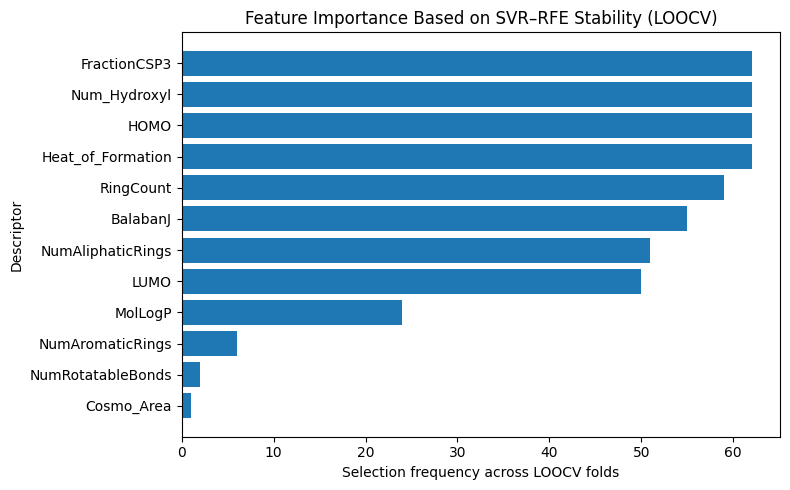

In [38]:
import matplotlib.pyplot as plt

# Sort just in case
fi = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(fi.index, fi.values)
plt.xlabel("Selection frequency across LOOCV folds")
plt.ylabel("Descriptor")
plt.title("Feature Importance Based on SVR–RFE Stability (LOOCV)")
plt.tight_layout()
plt.show()


# Method C : Gaussian Process for the Feature Selection 

In [39]:
X.shape

(62, 25)

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# ARD kernel: one lengthscale per feature
kernel = RBF(length_scale=[1.0]*X_scaled.shape[1], length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# Fit GP
gp.fit(X_scaled, y)


/home/omid/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/omid/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/omid/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 6 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/omid/.local/lib/python3.10/site-packages/sklearn/gaussian_process/k

GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10, normalize_y=True)

In [42]:
# Lengthscales for each feature
lengthscales = gp.kernel_.k1.length_scale  # k1 is the RBF part

# Smaller lengthscale = more important
feature_importance = pd.Series(1/lengthscales, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)


Kappa3               3.121599
Num_Hydroxyl         2.798486
Dipole_Moment        0.824507
BalabanJ             0.718794
LUMO                 0.385479
MolLogP              0.257434
HOMO                 0.203858
Kappa2               0.002442
NumRotatableBonds    0.002154
BertzCT              0.001293
RingCount            0.001000
MolWt                0.001000
Cosmo_Area           0.001000
Heat_of_Formation    0.001000
HeavyAtomCount       0.001000
NumAliphaticRings    0.001000
NumAromaticRings     0.001000
Chi1                 0.001000
Chi0                 0.001000
FractionCSP3         0.001000
TPSA                 0.001000
Kappa1               0.001000
Chi1v                0.001000
Chi0v                0.001000
HallKierAlpha        0.001000
dtype: float64


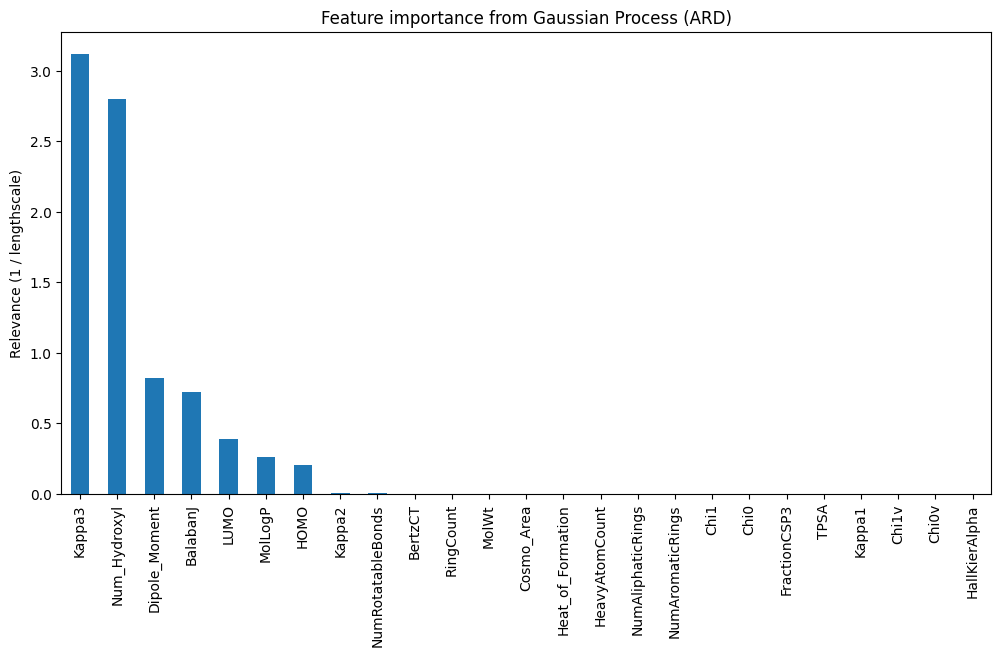

In [43]:
import matplotlib.pyplot as plt

feature_importance.plot(kind='bar', figsize=(12,6))
plt.ylabel("Relevance (1 / lengthscale)")
plt.title("Feature importance from Gaussian Process (ARD)")
plt.show()
    

In [44]:
top_n = 8
top_features = importance_sorted.head(top_n)

plt.figure(figsize=(10,5))
plt.bar(top_features.index, top_features.values, color='salmon')
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.title(f"Top {top_n} Features - {kernel_name}")
plt.show()


NameError: name 'importance_sorted' is not defined

# Modelling with ElasticNet Regression 

# Model A with features obtained from the removed correlated ones

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score    

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=0.2,
    random_state=42
)


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("elasticnet", ElasticNetCV(
        l1_ratio=np.linspace(0.1, 1.0, 10),
        alphas=np.logspace(-3, 2, 50),
        cv=cv,
        max_iter=10000
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('elasticnet',
                 ElasticNetCV(alphas=array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
       6.55128557e-03, 8.28642773e-03, 1.04811313e-02, 1.32571137e-02,
       1.67683294e-02, 2.12095089e-02, 2.68269580e-02, 3.39322177e-02,
       4.29193426e-02, 5.42867544...
       1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02]),
                              cv=KFold(n_splits=5, random_state=42, shuffle=True),
                              l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                              max_iter=10000))])

In [ ]:
y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)  

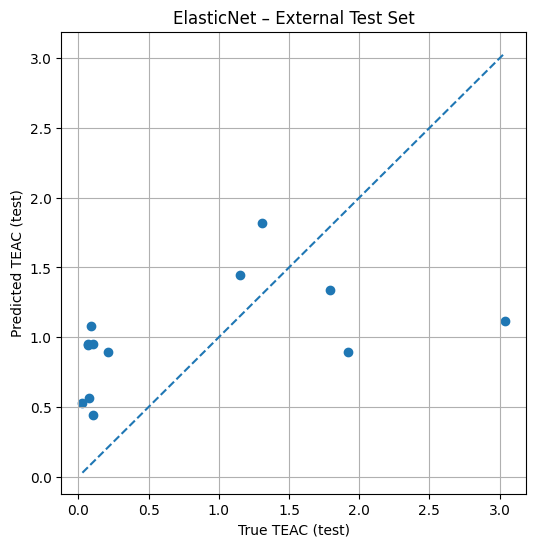

(np.float64(0.7406527644401628), 0.1728443991736719)

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "--")
plt.xlabel("True TEAC (test)")
plt.ylabel("Predicted TEAC (test)")
plt.title("ElasticNet – External Test Set")
plt.grid(True)
plt.show()
mse, r2

In [45]:
from sklearn.metrics import r2_score, root_mean_squared_error

#r2 = r2_score(y_test, y_test_pred)
#rmse = root_mean_squared_error(y_test, y_test_pred, squared=False)

#print(f"Test R²   = {r2:.3f}")
#print(f"Test RMSE = {rmse:.3f}")


# Y - Randomization on Method A 

In [46]:
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Parameters
n_random = 100  # number of randomizations
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Original model
model = Pipeline([
    ("scaler", StandardScaler()),
    ("elasticnet", ElasticNetCV(
        l1_ratio=np.linspace(0.1, 1.0, 10),
        alphas=np.logspace(-3, 2, 50),
        cv=cv,
        max_iter=10000
    ))
])

# Fit on original data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_original = r2_score(y_test, y_pred)
rmse_original = root_mean_squared_error(y_test, y_pred)

print(f"Original Test R² = {r2_original:.3f}, RMSE = {rmse_original:.3f}")

# -----------------------------
# Y-Randomization loop
# -----------------------------
r2_random = []
rmse_random = []

for i in range(n_random):
    y_train_shuffled = np.random.permutation(y_train)
    
    m = Pipeline([
        ("scaler", StandardScaler()),
        ("elasticnet", ElasticNetCV(
            l1_ratio=np.linspace(0.1, 1.0, 10),
            alphas=np.logspace(-3, 2, 50),
            cv=cv,
            max_iter=10000
        ))
    ])
    
    m.fit(X_train, y_train_shuffled)
    y_pred_rand = m.predict(X_test)
    
    r2_random.append(r2_score(y_test, y_pred_rand))
    rmse_random.append(root_mean_squared_error(y_test, y_pred_rand))

r2_random = np.array(r2_random)
rmse_random = np.array(rmse_random)


/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018051320804822524, tolerance: 0.005569358755102041
  model = cd_fast.enet_coordinate_descent_gram(
/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0375376413410784, tolerance: 0.005569358755102041
  model = cd_fast.enet_coordinate_descent_gram(
/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19152702673472533, tolerance: 0.005569358755102041
  model = cd_fast.enet_coordinate_descent_gram(
/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model

Original Test R² = nan, RMSE = 0.351


/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0182969498743617, tolerance: 0.005415642155102041
  model = cd_fast.enet_coordinate_descent_gram(
/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019012321926517473, tolerance: 0.005415642155102041
  model = cd_fast.enet_coordinate_descent_gram(
/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1809509239339988, tolerance: 0.005415642155102041
  model = cd_fast.enet_coordinate_descent_gram(
/home/omid/.local/lib/python3.10/site-packages/sklearn/linear_model/

# Gaussian Process Regression 

In [49]:
#  Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define kernel
# Constant * RBF kernel + WhiteKernel for noise
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))

# Fit Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train)

# Predictions
y_train_pred, y_train_std = gpr.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_std = gpr.predict(X_test_scaled, return_std=True)

# Evaluate
from sklearn.metrics import root_mean_squared_error, r2_score

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Train R² = {train_r2:.3f}, RMSE = {train_rmse:.3f}")
print(f"Test  R² = {test_r2:.3f}, RMSE = {test_rmse:.3f}")


Train R² = 0.558, RMSE = 0.730
Test  R² = 0.284, RMSE = 0.801


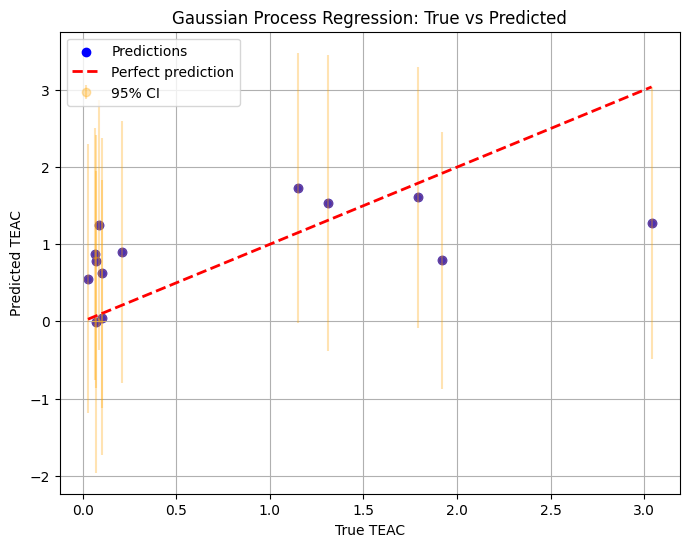

In [50]:
import matplotlib.pyplot as plt

# 1. Plot for TEST set
plt.figure(figsize=(8, 6))

# Predicted vs True
plt.scatter(y_test, y_test_pred, color='blue', label='Predictions')

# Confidence intervals (95%)
ci = 1.96 * y_test_std  # 1.96 ≈ 95% CI
plt.errorbar(y_test, y_test_pred, yerr=ci, fmt='o', alpha=0.3, color='orange', label='95% CI')

# Reference line y = x
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect prediction')

plt.xlabel("True TEAC")
plt.ylabel("Predicted TEAC")
plt.title("Gaussian Process Regression: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


#  Support Vector Regression for Method A 

In [52]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error
import numpy as np

# Prepare features and target ---
X = X_selected.copy()  # your selected important features
# y is already a numpy array, so no need for y = y.values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Feature scaling (important for SVR) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVR model
svr = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')  
svr.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = svr.predict(X_train_scaled)
y_test_pred = svr.predict(X_test_scaled)

# Evaluate
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Train R² = {train_r2:.3f}, RMSE = {train_rmse:.3f}")
print(f"Test  R² = {test_r2:.3f}, RMSE = {test_rmse:.3f}")



Train R² = 0.872, RMSE = 0.393
Test  R² = -0.932, RMSE = 1.315


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best SVR parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 0.01}
Train R² = 0.420, RMSE = 0.835
Test R² = 0.253, RMSE = 0.818
5-Fold CV R² = 0.122 ± 0.251


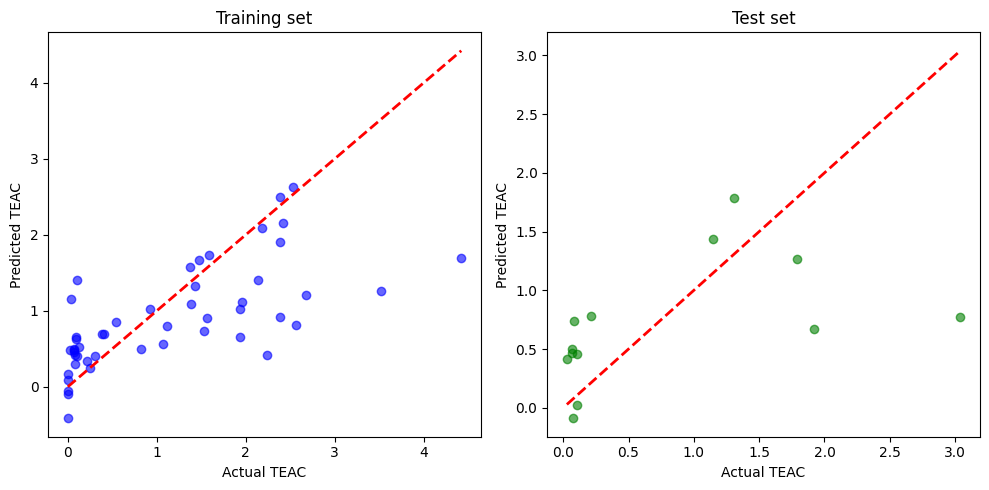

In [53]:
# --- 1. Wider Grid for SVR ---
param_grid = {
    'C': [1, 10, 50, 100, 500],       # wider range
    'epsilon': [0.001, 0.01, 0.05, 0.1],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best SVR parameters:", grid_search.best_params_)

# --- 2. Evaluate the best model ---
best_svr = grid_search.best_estimator_

y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Train R² = {train_r2:.3f}, RMSE = {train_rmse:.3f}")
print(f"Test R² = {test_r2:.3f}, RMSE = {test_rmse:.3f}")

# --- 3. 5-Fold CV ---
cv_scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"5-Fold CV R² = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- 4. Plot predicted vs actual ---
plt.figure(figsize=(10,5))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel("Actual TEAC")
plt.ylabel("Predicted TEAC")
plt.title("Training set")

# Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual TEAC")
plt.ylabel("Predicted TEAC")
plt.title("Test set")

plt.tight_layout()
plt.show()



Randomized R² (mean ± std): -0.21528368858579577 ± 0.27698456789094833


(array([1., 0., 2., 1., 1., 6., 3., 2., 1., 3.]),
 array([-0.90140313, -0.78586766, -0.67033219, -0.55479672, -0.43926125,
        -0.32372578, -0.20819031, -0.09265484,  0.02288063,  0.1384161 ,
         0.25395157]),
 <BarContainer object of 10 artists>)

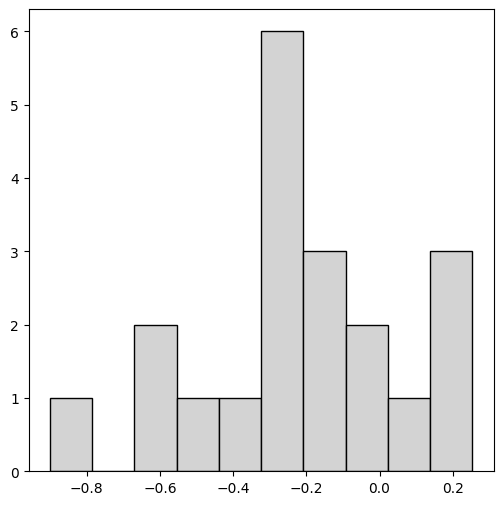

In [54]:
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np

n_random = 20
r2_random = []

for i in range(n_random):
    y_random = shuffle(y, random_state=i)
    svr_rand = SVR(C=best_svr.C, epsilon=best_svr.epsilon, gamma=best_svr.gamma)
    svr_rand.fit(X_train, y_random[:len(X_train)])
    y_pred_rand = svr_rand.predict(X_test)
    r2_random.append(r2_score(y_test, y_pred_rand))

print("Randomized R² (mean ± std):", np.mean(r2_random), "±", np.std(r2_random))
plt.figure(figsize=(6, 6))
plt.hist(r2_random, bins=10, color='lightgray', edgecolor='black')


/home/omid/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


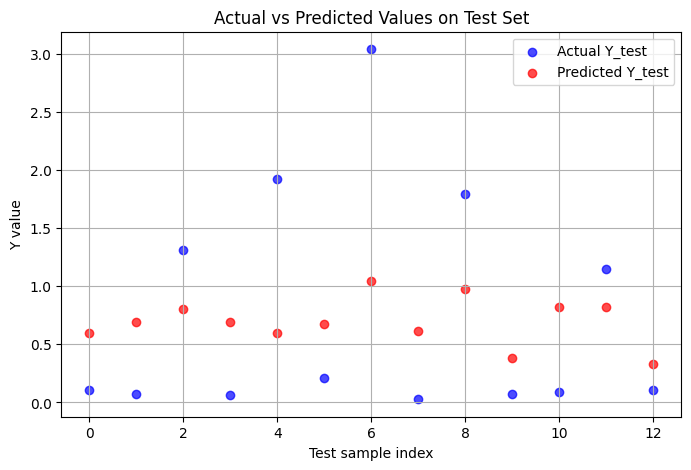

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Example: X_test indices for plotting
x_axis = np.arange(len(X_test))  # just 0, 1, 2, ..., n_test-1

# Predictions
y_test_pred = best_svr.predict(X_test)

plt.figure(figsize=(8,5))
plt.scatter(x_axis, y_test, color='blue', label='Actual Y_test', alpha=0.7)
plt.scatter(x_axis, y_test_pred, color='red', label='Predicted Y_test', alpha=0.7)
plt.xlabel("Test sample index")
plt.ylabel("Y value")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()
